<h2 style="text-align: center;"><b>Нейронная сеть из одного нейрона</b></h3>

---

<h3 style="text-align: center;"><b>Компоненты нейросети</b></h3>

Принципиальную роль в построении любой ***нейронной сети*** играют следующие вещи:

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количество итераций обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

Всё вышеперечисленное мы задаём *руками*, самостоятельно.

То, что связано с ***данными и задачей*** также имеет существенное влияние:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

<h3 style="text-align: center;"><b>Один нейрон на Keras</b></h3>

В качестве примера возьмём простой набор данных для классификации -- датасет "яблоки и груши":

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("apples_pears.csv")

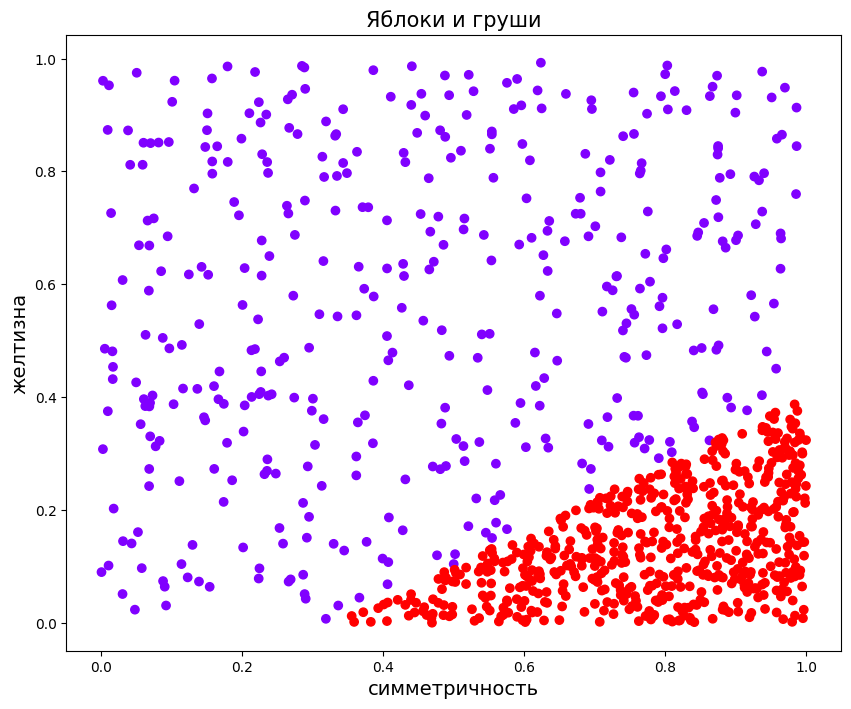

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=data['target'], cmap='rainbow')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [ ]:
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import sigmoid

In [ ]:
X[:,:10]

array([[0.77942731, 0.25730527],
       [0.77700501, 0.0159154 ],
       [0.97709225, 0.30420962],
       ...,
       [0.92721921, 0.13498618],
       [0.01582991, 0.48132194],
       [0.96796389, 0.30857107]])

In [ ]:
num_features = X.shape[1]

neuron = Sequential()
neuron.add(Dense(1, input_shape=(num_features,), activation=sigmoid))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
neuron

<Sequential name=sequential, built=True>

Пока что мы просто создали объект класса `Sequential`, который состоит из одного линейного входного слоя размерности (num_features, 1) и 1 нейрона с сигмоидой в качестве активационной функции. Но уже сейчас его можно применить к объекту (тензору), просто веса в начале инициализирутся случайно и при forward_pass'е мы получим какой-то ответ пока что необученного нейрона:

In [ ]:
neuron.predict([[1,1]])

ValueError: Unrecognized data type: x=[[1, 1]] (of type <class 'list'>)

Выполним предсказания по всем данным с помощью ещё не обученного нейрона:

In [ ]:
proba_pred = neuron.predict(X)
y_pred = proba_pred > 0.5
print(y_pred[:5])
y_pred = y_pred.reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Как и ожидалось, ошибка существенная, по сути, модель не умеет различать классы. Давайте научим нейрон отличать груши от яблок по их симметричности и желтизне!

## Код обучения одного нейрона на Keras:

Обучим нейрон с использованием метода SGD (стохастический градиентный спуск).
Нам понадобится пакет Keras.optimizers, который содержит различные алгоритмы оптимизации.

Зададим параметры:
- затухание весов 1e-6
- момент 0.9
- включим поддержку ускоренного градиента Нестерова (http://proceedings.mlr.press/v28/sutskever13.pdf)
- шаг обучения установим равным 0.1

Не забываем накапливать историю обучения - понадобится для построения графиков

In [ ]:
import tensorflow as tf
from tensorflow.keras import optimizers
sgd = optimizers.SGD(decay=1e-6, momentum=0.9, nesterov=True, learning_rate=0.01)
neuron.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])
history=neuron.fit(X, y, epochs=100, batch_size=25, verbose=1, validation_split=0.2)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
#plt.legend(['train','test'])
plt.show()




In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Обучили. Снова выполним предсказания, но уже с помощью обученной модели.

In [ ]:
proba_pred = neuron.predict(X)
y_pred = proba_pred > 0.5
y_pred = y_pred.reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

<h2 style="text-align: center;"><b>Многослойная сеть на Keras</b></h3>

---

## Многослойная нейронная сеть

Как можно понять из названия, многослойная нейросеть состоит из нескольких **слоёв**. Ещё такую многослойную нейросеть, у которой каждый нейрон на предыдущем уровне соединён с нейроном на следующем уровне, называют ***Fully-Connected-сетью*** (или ***Dense-сетью***).  

Расмотрим их устройство более подробно:

* Вот так выглядит двухслойная нейросеть (первый слой - input layer - не считается, потому что это, по сути, не слой):

<img src="http://cs231n.github.io/assets/nn1/neural_net.jpeg" width=300, height=200>

* Так выглядит трёхслойная нейросеть:

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" width=400, height=300>

.. и так далее для большего случая слоёв.

**Обратите внимание:** связи есть от каждого нейрона слоя $L_{i-1}$ к каждому нейрону слоя $L_{i}$, но между нейронами в одном слое связей **нет**.

**Входной слой** -- это данные (матрица $(n, m)$).

Слои, которые не являются входными или выходными, называются **скрытыми слоями (hidden layers)**.

При решении ***задачи регрессии*** в **выходном слое** есть только один нейрон, который возвращает предсказанные числа (для каждого объекта по числу).  

В случае решения ***задачи классификации*** в **выходном слое** может быть как один, так и несколько нейронов. Если решается задача бинарной классификации, то слой содержит один нейрон и $K$ нейронов, если решается задача $K$-класовой классификации.

#### Прямое распространение

Каждый слой многослойной нейросети - это матрица весов, столбцы которой -- это нейроны (один столбец - один нейрон). То есть один столбец -- это веса одного нейрона.

Допустим, мы решаем задачу $K$-классовой классификации (на последнем слое $K$ нейронов). Рассмотрим, как в таком случае выглядит `forward_pass` нейросети:

* Вход: $$X =
\left(
\begin{matrix}
x_{11} & ... & x_{1M} \\
... & \ddots  & ...\\
x_{N1} & ... & x_{NM}
\end{matrix}
\right)
$$

-- матрица $(N, M)$

* Структура сети - много слоёв, в слоях много нейронов. Первый слой (после входного) выглядит так:

$$ W^1 =
\left(
\begin{matrix}
w_{11} & ... & w_{1L_1} \\
... & \ddots  & ...\\
w_{M1} & ... & w_{ML_1}
\end{matrix}
\right)
$$

-- матрица $(M, L_1)$

То есть это в точности $L_1$ нейронов, каждый имеет свои собственные веса, их $M$ штук.

Мы помним, что нейрон - это линейное преобразование и потом нелинейная функция активации от этого преобразования. Однако в многослойных нейростеях часто отделяют `Linear` часть и `Activation`, то есть слоем считаем набор весов нейронов, а следующий слой всегда функция активации (у всех нейронов из слоя она одна и та же, обычно фреймворки не позволяют задавать конкретному нейрону в слое отличную от других нейронов в этом слое функцию активации, однако это легко сделать, объявив слой из одного нейрона).

* Другие слои выглядит точно так же, как первый слой. Например, второй слой будет такой:

$$ W^2 =
\left(
\begin{matrix}
w_{11} & ... & w_{1L_2} \\
... & \ddots  & ...\\
w_{L_11} & ... & w_{L_1L_2}
\end{matrix}
\right)
$$

-- матрица $(L_1, L_2)$

То есть это в точности $L_2$ нейронов, каждый имеет свои собственные веса, их $L_1$ штук.

* Выходной слой:  

Пусть в нейросети до выходного слоя идут $t$ слоёв. Тогда выходной слой имеет форму:

$$ W^{out} =
\left(
\begin{matrix}
w_{11} & ... & w_{1K} \\
... & \ddots  & ...\\
w_{L_t1} & ... & w_{L_tK}
\end{matrix}
\right)
$$

-- матрица $(L_t, K)$, где $L_t$ - количество нейронов в $t$-ом слое, а $K$ -- количество классов.

В итоге *для `forward_pass` нам нужно просто последовтельно перемножить матрицы друг за другом, применяя после каждого умножения соответсвующую функцию активации*.

*Примечание*: можно думать об умножении на очередную матрицу весов как на переход в **новое признаковое пространство**. Действительно, когда подаём матрицу $X$ и умножаем на матрицу первого слоя, мы получаем матрицу размера $(N, L_1)$, то есть как будто $L_1$ "новых" признаков (построенных как линейная комбинация старых до применения функции активации, и уже как нелинейная комбинация после активации). Здесь уместно вспомнить, что Deep Learning является пообластью Representation Learning, то есть позволяет выучивает новые представляения данных.

**Обратное распространение**

Обучается с помощью метода "Error Backpropagation" - ["Обратное распространение ошибки"](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BE%D0%B1%D1%80%D0%B0%D1%82%D0%BD%D0%BE%D0%B3%D0%BE_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%BE%D1%81%D1%82%D1%80%D0%B0%D0%BD%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BE%D1%88%D0%B8%D0%B1%D0%BA%D0%B8), принцип распространения очень похож на то, как мы обучали один нейрон - это градиентный спуск, но по "всей нейросети" сразу.  

Backpropagation работает корректно благодаря ***chain rule*** (=правилу взятия производной сложной функции):  

Если $f(x) = f(g(x))$, то:  

$$\frac{\partial{f}}{\partial{x}} = \frac{\partial{f}}{\partial{g}} \frac{\partial{g}}{\partial{x}}$$

Более подробно про backpropagation можно прочитать здесь (на английском):  https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/

# Создание двухслойной нейросети
Cоздадим двухслойную нейросеть из 100 нейронов:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import keras

Генерация датасета:

In [ ]:
N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j,N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4,N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)
plt.title('Спираль', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

In [ ]:
print(X.data.shape, y.data.shape)

In [ ]:
from keras.utils import np_utils
y = keras.utils.np_utils.to_categorical(y, 3)


In [ ]:
from keras import optimizers
two_layer_net=keras.models.Sequential()
two_layer_net.add(keras.layers.Dense(100, input_shape=(X.shape[1],), activation='relu'))
two_layer_net.add(keras.layers.Dense(3, activation='softmax'))
print(two_layer_net.summary())


In [ ]:
#визуализация модели
from keras.utils.vis_utils import plot_model
plot_model(two_layer_net, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras import optimizers
sgd = optimizers.SGD(decay=1e-6, momentum=0.9, nesterov=True, learning_rate=0.01)
two_layer_net.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history=two_layer_net.fit(X, y, epochs=150, batch_size=64, verbose=1, validation_split=0.2)


In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
#plt.legend(['train','test'])
plt.show()

# Создание многослойной нейросети
Усложним архитектуру нейронной сети прямого распространения:

In [ ]:
many_layer_net=keras.models.Sequential()
two_layer_net.add(keras.layers.Dense(100, input_shape=(X.shape[1],), activation='relu'))
two_layer_net.add(keras.layers.Dense(100, activation='relu'))

two_layer_net.add(keras.layers.Dense(100, activation='relu'))
two_layer_net.add(keras.layers.Dense(3, activation='softmax'))
sgd = optimizers.SGD(decay=1e-6, momentum=0.9, nesterov=True, learning_rate=0.001)
two_layer_net.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history=two_layer_net.fit(X, y, epochs=150, batch_size=64, verbose=1, validation_split=0.2)


In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Создание многослойной нейросети для классификации рукописных цифр

In [ ]:
import keras

from keras.datasets import mnist
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.models import Sequential
from keras.optimizers import adam_v2
from keras.utils import np_utils
from keras.utils import np_utils

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

number_of_classes = 10

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

plt.figure()
plt.imshow(X_train[0])
plt.colorbar()
plt.grid(False)


In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)


In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]).astype('float32')
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]).astype('float32')

#для преобразования двумерных данных в одномерные в нейронной сети можно использовать слой Flatten(input_shape=(28,28))

X_train/=255
X_test/=255

y_train = np_utils.to_categorical(y_train, number_of_classes)
y_test = np_utils.to_categorical(y_test, number_of_classes)

In [ ]:
X_train.shape

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(512, input_dim=(X_train.shape[1]), activation='relu'))
model.add(keras.layers.Dense(number_of_classes, activation='softmax'))
print(model.summary())


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=200)


In [ ]:
#оценка точности
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set(title='model accuracy')
ax1.set(ylabel='accuracy')
ax1.set(xlabel='epoch')
ax1.legend(['train', 'test'], loc='upper left')
ax2 = fig.add_subplot(1,2,2)
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set(title='model loss')
ax2.set(ylabel='loss')
ax2.set(xlabel='epoch')
ax2.legend(['train', 'test'], loc='upper left')
plt.show()


# Инициализация сети
Важным моментом при конструировании сети является начальная инициализация весов. Удачно выбранный способ инициализации весов может значительно влиять на способность модели к обучению.

Существует различные подходы к начальной инициализации весов.

Например, метод Завьера. Основная идея этого метода — упростить прохождение сигнала через слой во время как прямого, так и обратного распространения ошибки для линейной функции активации (этот метод также хорошо работает для сигмоидной функции, так как участок, где она ненасыщена, также имеет линейный характер). При вычислении весов этот метод опирается на вероятностное распределение.

Метод инициализации Ге (He) — это вариация метода Завьера, больше подходящая функции активации ReLU, компенсирующая тот факт, что эта функция возвращает нуль для половины области определения.

Выделяют также метод ортогональной инициализации.

In [ ]:
model_reg = keras.models.Sequential()
model_reg.add(keras.layers.Dense(512, input_dim=(X_train.shape[1]), activation='relu', kernel_initializer='he_uniform'))
model_reg.add(keras.layers.Dense(number_of_classes, activation='softmax', kernel_initializer='glorot_uniform'))

# L2-регуляризация
Одной из основных проблем машинного обучения является проблема переобучения (overfitting), когда модель в погоне за минимизацией затрат на обучение теряет способность к обобщению.

Существует простой способ держать переобучение под контролем — метод dropout.

Но есть и другие регуляризаторы, которые можно применить к сети. Один из них — L_2-регуляризация (также называемая сокращением весов, англ. weight decay), которая использует более прямой подход к регуляризации, чем dropout. Обычно первопричиной переобучения является сложность модели (в смысле количества ее параметров), слишком высокая для решаемой задачи и имеющегося обучающего множества. В некотором смысле, задача регуляризатора — понизить сложность модели, сохранив количество ее параметров.

L_2-регуляризация выполняется посредством наложения штрафов (penalising) на веса с наибольшими значениями, минимизируя их L_2-норму с использованием параметра λ — коэффициент регуляризации, выражающий предпочтение минимизации нормы относительно минимизации потерь на обучающем множестве.

Крайне важно правильно выбрать λ. Если коэффициент слишком мал, то эффект от регуляризации будет ничтожен, если же слишком велик — модель обнулит все веса.

In [ ]:
from keras.regularizers import l2
l2_lambda = 0.0001
model_reg = keras.models.Sequential()
model_reg.add(keras.layers.Dense(512, input_dim=(X_train.shape[1]), activation='relu',kernel_initializer='he_uniform', bias_regularizer=l2(l2_lambda)))
model_reg.add(keras.layers.Dense(number_of_classes, activation='softmax', kernel_initializer='glorot_uniform'))

In [ ]:
model_reg.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model_reg.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=200)

## Применение обученной нейронной сети
Необходимо нарисовать цифру (например в Paint) или скачать из Интернета

In [ ]:
#выполняем преобразование картинки с цифрой
from PIL import Image
#преобразование входного изображения в формат набора MNIS
image=Image.open("cifra-2.png").resize((28,28))
img = np.invert(image.convert('L')).ravel()
im2arr = img.reshape(1, 28* 28).astype('float32')/255
#plt.imshow(image, cmap=plt.cm.binary)
#использование обученной модели
y_pred = model.predict(im2arr)
print(y_pred[0])
plt.bar(range(10), y_pred[0])
plt.show()
print(np.argmax(y_pred))

In [ ]:
#сохранение модели
model.save('model.h5')

#загрузка модели
#model_load=keras.models.load_model('model.h5')

## Задание 1

Для набора данных "Спираль"
1. Попробуйте улучшить результат классификации за счет изменения следующих параметров: скорость обучения, количество эпох, виды оптимизаторов, количество нейронов, количество слоев. Результаты анализа представьте в виде графиков (диаграмм).
2. Добавьте слой (слои) Dropout (model.add(keras.layers.Dropout(0.5))), посмотрите, как изменится результат.
3. Добавьте слой нормализации (keras.layers.BatchNormalization) и оцените его влияние на качество обучения. Сделайте выводы.

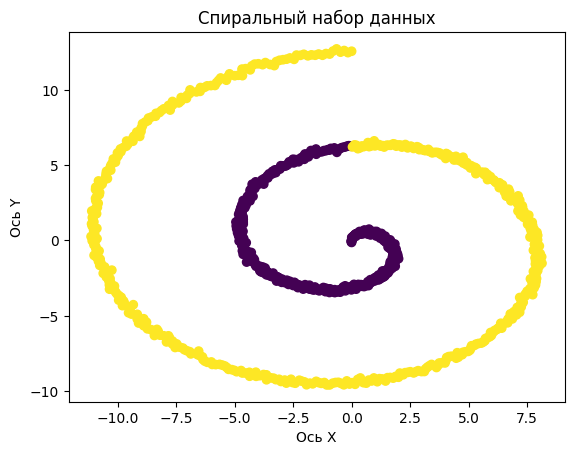

In [31]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD

# Генерация спирального набора данных
def make_spiral(n_samples=1000, noise=0.1):
    theta = np.linspace(0, 4 * np.pi, n_samples)
    r = theta + np.random.randn(n_samples) * noise
    x = r * np.sin(theta)
    y = r * np.cos(theta)
    return np.column_stack((x, y)), (theta > 2 * np.pi).astype(int)

# Создание спирального набора данных
X, y = make_spiral()
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title('Спиральный набор данных')
plt.xlabel('Ось X')
plt.ylabel('Ось Y')
plt.show()


In [32]:
def create_model(learning_rate=0.01, neurons=64, layers=2, dropout_rate=0.0, use_batch_norm=False):
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_shape=(2,)))

    if use_batch_norm:
        model.add(BatchNormalization())

    for _ in range(layers - 1):
        model.add(Dense(neurons, activation='relu'))
        if use_batch_norm:
            model.add(BatchNormalization())

    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [33]:
def train_model(model, X, y, epochs=20, batch_size=32):
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)
    return history


In [66]:
# Параметры для экспериментов
learning_rates = [0.001]
neurons_list = [32]
layers_list = [2]
dropout_rates = [0.5]
batch_norm_options = [True]


results = {}

for lr in learning_rates:
    for neurons in neurons_list:
        for layers in layers_list:
            for dropout in dropout_rates:
                for batch_norm in batch_norm_options:
                    model = create_model(learning_rate=lr, neurons=neurons, layers=layers, dropout_rate=dropout, use_batch_norm=batch_norm)
                    history = train_model(model, X, y, epochs=100)
                    results[(lr, neurons, layers, dropout, batch_norm)] = history.history['accuracy']


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


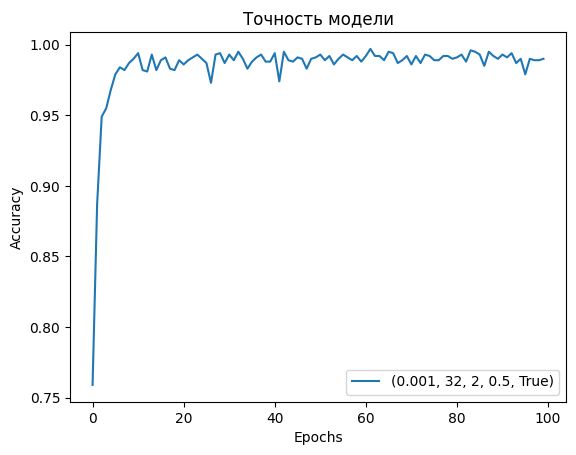

In [67]:
for key, accuracy in results.items():
    plt.plot(accuracy, label=str(key))

plt.title('Точность модели')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


###Результаты:

####Дропаут Рейт

1) dropout_rates = [0.1]

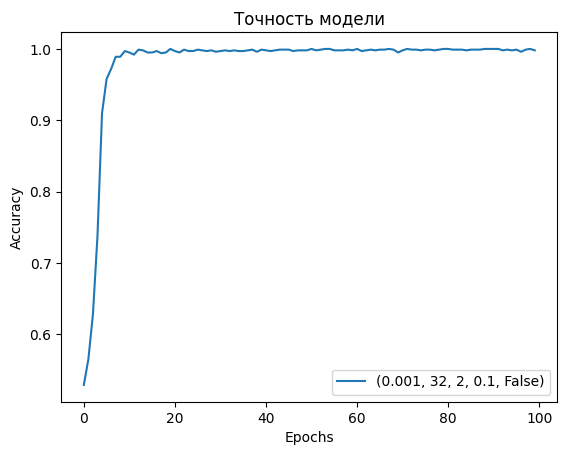

2) dropout_rates = [0.5]

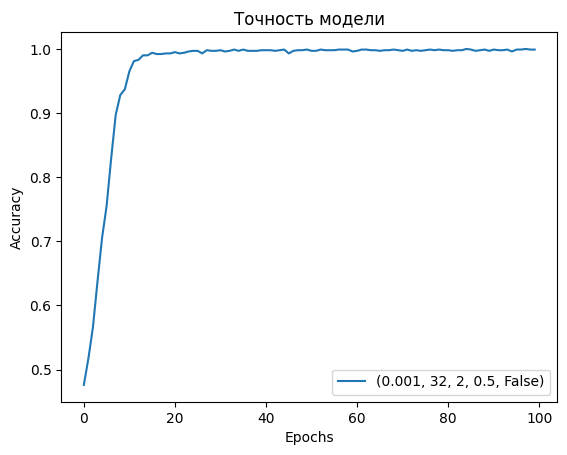

3) dropout_rates = [0.7]

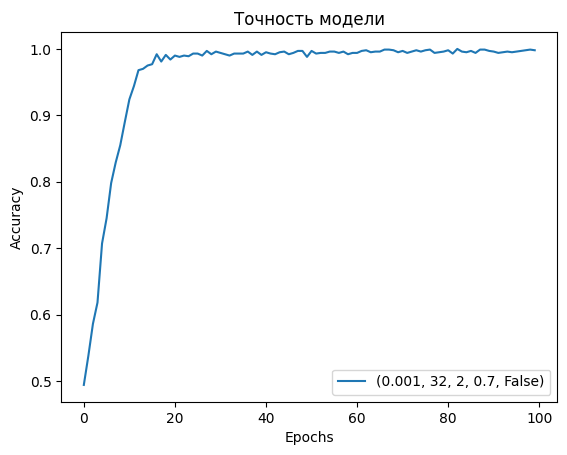

4) dropout_rates = [0.9]

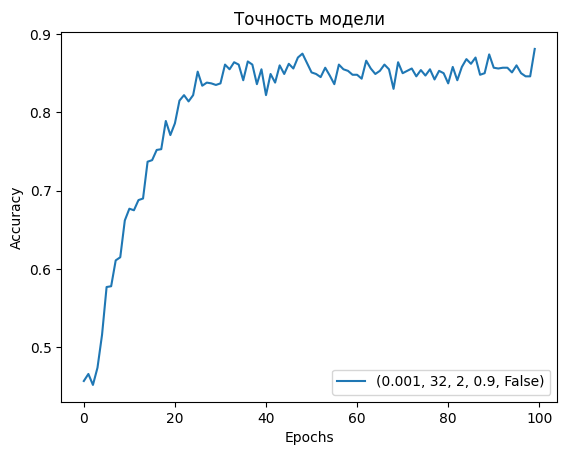

####Батч Нормализация

**True**

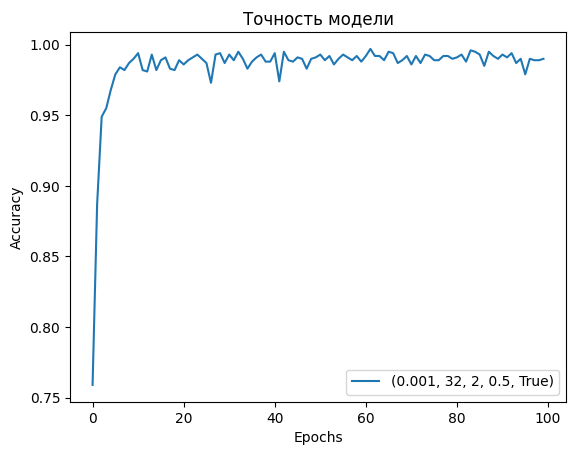

**False**

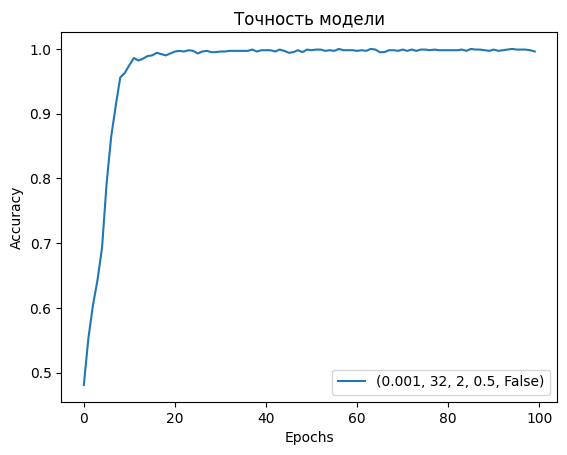

## Задание 2
Для набора данных MNIST
1. Между двух слоев нейронной сети добавить слой Dropout
model.add(keras.layers.Dropout(0.5)), переобучить модель, оценить качество обучения.
Объяснить полученные результаты
2. Добавить еще один скрытый слой и проанализировать его влияние на качество обучения модели.

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

# Загрузка набора данных MNIST
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Преобразование данных
X_train = X_train.reshape((X_train.shape[0], 28 * 28))
X_test = X_test.reshape((X_test.shape[0], 28 * 28))


Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7855 - loss: 0.6909 - val_accuracy: 0.9509 - val_loss: 0.1686
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9250 - loss: 0.2439 - val_accuracy: 0.9614 - val_loss: 0.1276
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9391 - loss: 0.2026 - val_accuracy: 0.9642 - val_loss: 0.1174
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9441 - loss: 0.1787 - val_accuracy: 0.9688 - val_loss: 0.1051
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9501 - loss: 0.1616 - val_accuracy: 0.9697 - val_loss: 0.1000
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9538 - loss: 0.1500 - val_accuracy: 0.9722 - val_loss: 0.0987
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9529 - loss: 0.1478 - val_accuracy: 0.9729 - val_loss: 0.0930
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9548 - loss: 0.1380

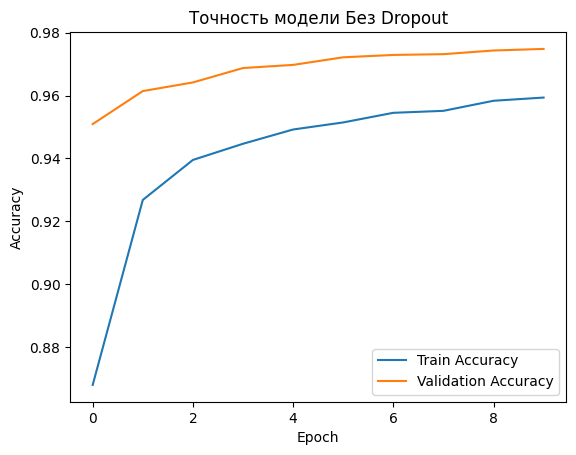

In [79]:
def create_model_without_dropout():
    model = keras.Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape=(28 * 28,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Создание и обучение модели
model_with_dropout = create_model_with_dropout()
history_with_dropout = model_with_dropout.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)

# Оценка модели
test_loss, test_accuracy1 = model_with_dropout.evaluate(X_test, y_test)
print(f"Тестовая точность без Dropout: {test_accuracy1:.4f}")

# Визуализация истории обучения
plt.plot(history_with_dropout.history['accuracy'], label='Train Accuracy')
plt.plot(history_with_dropout.history['val_accuracy'], label='Validation Accuracy')
plt.title('Точность модели Без Dropout')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7757 - loss: 0.7091 - val_accuracy: 0.9519 - val_loss: 0.1689
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9263 - loss: 0.2461 - val_accuracy: 0.9604 - val_loss: 0.1326
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9377 - loss: 0.2026 - val_accuracy: 0.9638 - val_loss: 0.1236
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9442 - loss: 0.1795 - val_accuracy: 0.9682 - val_loss: 0.1061
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9493 - loss: 0.1626 - val_accuracy: 0.9722 - val_loss: 0.0949
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9535 - loss: 0.1501 - val_accuracy: 0.9722 - val_loss: 0.0946
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9555 - loss: 0.1416 - val_accuracy: 0.9743 - val_loss: 0.0889
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9601 - loss: 0.1326 

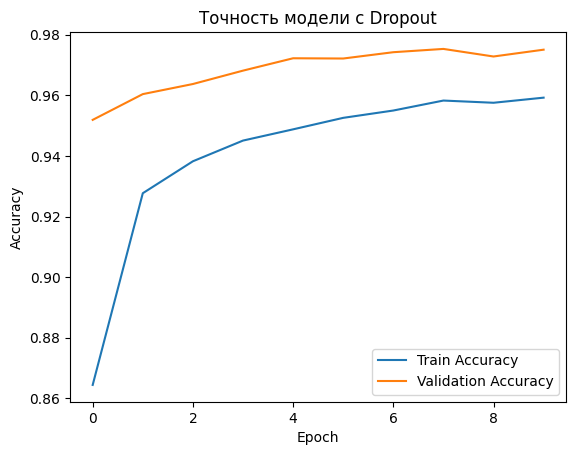

In [80]:
def create_model_with_dropout():
    model = keras.Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape=(28 * 28,)))
    model.add(layers.Dropout(0.5))  # Добавляем слой Dropout
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Создание и обучение модели
model_with_dropout = create_model_with_dropout()
history_with_dropout = model_with_dropout.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)

# Оценка модели
test_loss, test_accuracy2 = model_with_dropout.evaluate(X_test, y_test)
print(f"Тестовая точность с Dropout: {test_accuracy2:.4f}")

# Визуализация истории обучения
plt.plot(history_with_dropout.history['accuracy'], label='Train Accuracy')
plt.plot(history_with_dropout.history['val_accuracy'], label='Validation Accuracy')
plt.title('Точность модели с Dropout')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7636 - loss: 0.7246 - val_accuracy: 0.9498 - val_loss: 0.1701
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9197 - loss: 0.2572 - val_accuracy: 0.9584 - val_loss: 0.1333
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9313 - loss: 0.2203 - val_accuracy: 0.9616 - val_loss: 0.1263
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9417 - loss: 0.1885 - val_accuracy: 0.9682 - val_loss: 0.1114
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9469 - loss: 0.1747 - val_accuracy: 0.9670 - val_loss: 0.1079
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9512 - loss: 0.1557 - val_accuracy: 0.9693 - val_loss: 0.1036
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9523 - loss: 0.1556 - val_accuracy: 0.9699 - val_loss: 0.1101
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9556 - loss: 0.141

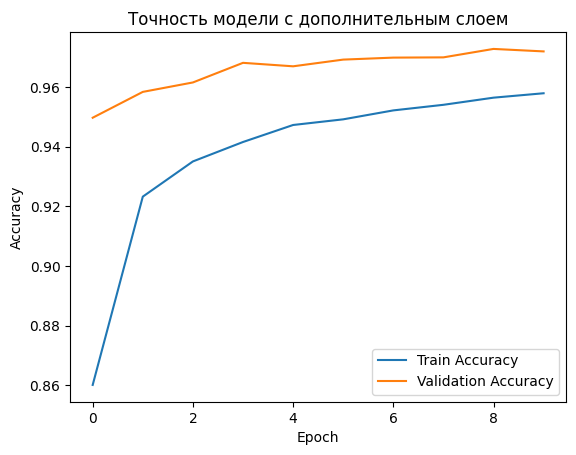

In [81]:
def create_model_with_additional_layer():
    model = keras.Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape=(28 * 28,)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))  # Новый скрытый слой
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Создание и обучение модели с дополнительным слоем
model_with_additional_layer = create_model_with_additional_layer()
history_with_additional_layer = model_with_additional_layer.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)

# Оценка модели
test_loss, test_accuracy3 = model_with_additional_layer.evaluate(X_test, y_test)
print(f"Точность теста с дополнительным слоем: {test_accuracy3:.4f}")

# Визуализация истории обучения
plt.plot(history_with_additional_layer.history['accuracy'], label='Train Accuracy')
plt.plot(history_with_additional_layer.history['val_accuracy'], label='Validation Accuracy')
plt.title('Точность модели с дополнительным слоем')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [82]:
print(f"Тестовая точность без Dropout: {test_accuracy1:.4f}")
print(f"Тестовая точность с Dropout: {test_accuracy2:.4f}")
print(f"Точность теста с дополнительным слоем: {test_accuracy3:.4f}")

Тестовая точность без Dropout: 0.9728
Тестовая точность с Dropout: 0.9753
Точность теста с дополнительным слоем: 0.9732


## Задание 3
1. Создайте модель нейронной сети для решения задачи классификации из Лабораторной работы №5, в соответствии с вариантом задания
1. Обучите модель. В завсимости от результатов, видоизмените модель, чтобы попытаться добиться большей точности


In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

In [109]:
# Загрузка набора данных
data = pd.read_csv('exam_регр.csv', delimiter=';')

bins = [0, 50, 75, 100]
labels = [0, 1, 2]
data['class'] = pd.cut(data['mean_exam_points'], bins=bins, labels=labels, right=True)

# Определяем признаки и целевую переменную
X = data[['age', 'years_of_experience', 'lesson_price', 'qualification', 'physics', 'chemistry', 'biology', 'english', 'geography', 'history']]
y = data['class'].values

# Кодирование категориальных переменных
label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X.loc[:, column] = le.fit_transform(X[column])
    label_encoders[column] = le

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Стандартизация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(32)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6144 - loss: 0.8929 - val_accuracy: 0.7825 - val_loss: 0.5908
Epoch 2/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8028 - loss: 0.5357 - val_accuracy: 0.7980 - val_loss: 0.5026
Epoch 3/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8066 - loss: 0.4758 - val_accuracy: 0.8005 - val_loss: 0.4837
Epoch 4/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8103 - loss: 0.4537 - val_accuracy: 0.8005 - val_loss: 0.4761
Epoch 5/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8142 - loss: 0.4421 - val_accuracy: 0.8005 - val_loss: 0.4724
Epoch 6/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8132 - loss: 0.4360 - val_accuracy: 0.8000 - val_loss: 0.4677
Epoch 7/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8156 - loss: 0.4286 - val_accuracy: 0.8000 - val_loss: 0.4681
Epoch 8/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8133 - loss: 0.4298 - val_accuracy: 0.8020 - val_

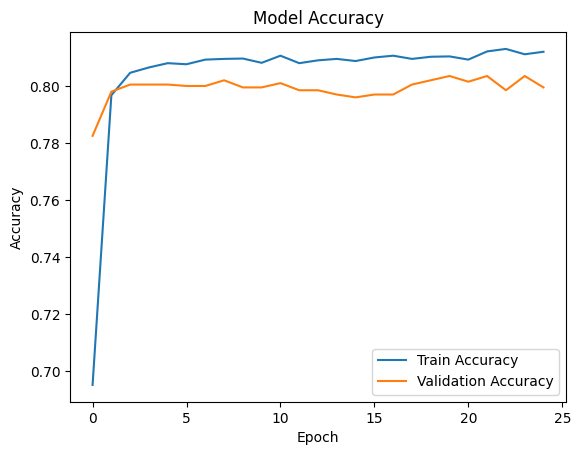

In [110]:
def create_model():
    model = keras.Sequential()
    model.add(layers.Dense(10, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))  # 3 класса
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Создание и обучение модели
model = create_model()
history = model.fit(train_dataset, epochs=25, validation_data=test_dataset)

# Оценка модели
test_loss, test_accuracy1 = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy1:.4f}")

# Визуализация истории обучения
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7005 - loss: 0.7669 - val_accuracy: 0.8010 - val_loss: 0.4902
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7971 - loss: 0.4876 - val_accuracy: 0.7980 - val_loss: 0.4739
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8074 - loss: 0.4569 - val_accuracy: 0.8020 - val_loss: 0.4649
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8048 - loss: 0.4605 - val_accuracy: 0.8075 - val_loss: 0.4517
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8060 - loss: 0.4429 - val_accuracy: 0.7955 - val_loss: 0.4681
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8068 - loss: 0.4480 - val_accuracy: 0.8080 - val_loss: 0.4451
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8140 - loss: 0.4286 - val_accuracy: 0.8105 - val_loss: 0.4440
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8060 - loss: 0.4366 - val_accuracy: 0.

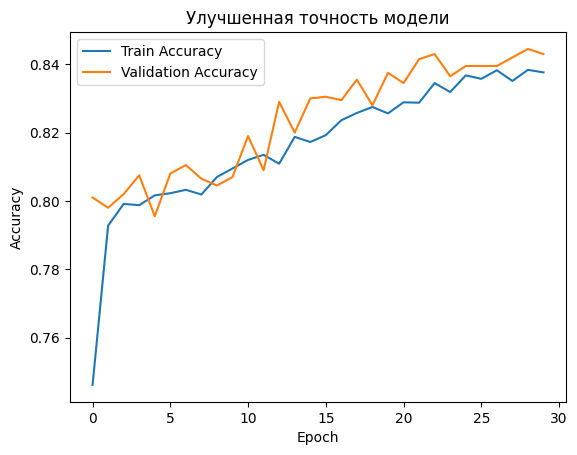

In [111]:
def create_model_improved():
    model = keras.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))  # Увеличение числа нейронов
    model.add(layers.Dropout(0.5))  # Слой Dropout для регуляризации
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))  # Новый скрытый слой
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Изменение скорости обучения
    return model

# Создание и обучение улучшенной модели
improved_model = create_model_improved()
history_improved = improved_model.fit(train_dataset, epochs=30, validation_data=test_dataset)

# Оценка улучшенной модели
test_loss, test_accuracy2 = improved_model.evaluate(test_dataset)
print(f"Тестовая точность улучшенной модели: {test_accuracy2:.4f}")

# Визуализация истории обучения улучшенной модели
plt.plot(history_improved.history['accuracy'], label='Train Accuracy')
plt.plot(history_improved.history['val_accuracy'], label='Validation Accuracy')
plt.title('Улучшенная точность модели')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Epoch 1/45
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7528 - loss: 0.6105 - val_accuracy: 0.8000 - val_loss: 0.4893
Epoch 2/45
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8025 - loss: 0.4701 - val_accuracy: 0.8045 - val_loss: 0.4555
Epoch 3/45
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8099 - loss: 0.4554 - val_accuracy: 0.8010 - val_loss: 0.4548
Epoch 4/45
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8134 - loss: 0.4460 - val_accuracy: 0.7990 - val_loss: 0.4635
Epoch 5/45
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8068 - loss: 0.4516 - val_accuracy: 0.8030 - val_loss: 0.4441
Epoch 6/45
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8102 - loss: 0.4451 - val_accuracy: 0.7990 - val_loss: 0.4444
Epoch 7/45
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8094 - loss: 0.4400 - val_accuracy: 0.8065 - val_loss: 0.4349
Epoch 8/45
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8101 - loss: 0.4306 - val_accuracy: 0.

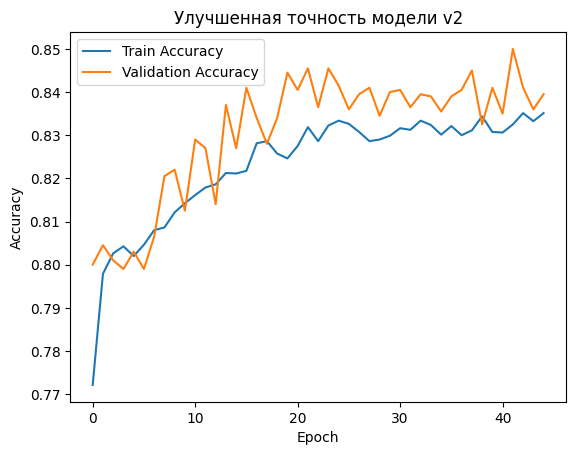

In [112]:
def create_model_improved_v2():
    model = keras.Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dropout(0.5))  # Слой Dropout для регуляризации
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Еще один слой Dropout
    model.add(layers.Dense(64, activation='relu'))  # Новый скрытый слой
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Изменение скорости обучения
    return model

# Создание и обучение улучшенной модели
improved_model_v2 = create_model_improved_v2()
history_improved_v2 = improved_model_v2.fit(train_dataset, epochs=45, validation_data=test_dataset)

# Оценка улучшенной модели
test_loss, test_accuracy3 = improved_model_v2.evaluate(test_dataset)
print(f"Тестовая точность улучшенной модели v2: {test_accuracy3:.4f}")

# Визуализация истории обучения улучшенной модели
plt.plot(history_improved_v2.history['accuracy'], label='Train Accuracy')
plt.plot(history_improved_v2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Улучшенная точность модели v2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7452 - loss: 0.6090 - val_accuracy: 0.8055 - val_loss: 0.4746
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8067 - loss: 0.4689 - val_accuracy: 0.8010 - val_loss: 0.4623
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8062 - loss: 0.4533 - val_accuracy: 0.8030 - val_loss: 0.4626
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8127 - loss: 0.4477 - val_accuracy: 0.8075 - val_loss: 0.4586
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8066 - loss: 0.4460 - val_accuracy: 0.8025 - val_loss: 0.4441
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8114 - loss: 0.4397 - val_accuracy: 0.8095 - val_loss: 0.4400
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8146 - loss: 0.4302 - val_accuracy: 0.8000 - val_loss: 0.4453
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8143 - loss: 0.4205 - val_accuracy: 0.

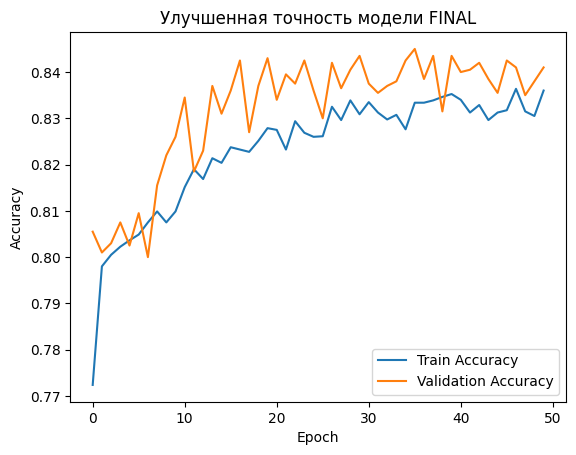

In [115]:
from keras.callbacks import EarlyStopping

def create_model_improved_final():
    model = keras.Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.BatchNormalization())  # Добавление Batch Normalization
    model.add(layers.Dropout(0.5))  # Слой Dropout для регуляризации
    model.add(layers.Dense(128, activation='relu'), kernel_regularizer=regularizers.l2(0.001)) #L2-регуляризацию к слоям Dense
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Изменение скорости обучения
    return model

#стопер на случай если не будет роста в точности
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Создание и обучение улучшенной модели
improved_model_v2 = create_model_improved_v2()
history_improved_v2 = improved_model_v2.fit(train_dataset, epochs=50, validation_data=test_dataset)

# Оценка улучшенной модели
test_loss, test_accuracy4 = improved_model_v2.evaluate(test_dataset)
print(f"Тестовая точность улучшенной модели FINAL: {test_accuracy4:.4f}")

# Визуализация истории обучения улучшенной модели
plt.plot(history_improved_v2.history['accuracy'], label='Train Accuracy')
plt.plot(history_improved_v2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Улучшенная точность модели FINAL')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [116]:
print(f"Тестовая точность: {test_accuracy1:.4f}")
print(f"Тестовая точность улучшенной модели: {test_accuracy2:.4f}")
print(f"Тестовая точность улучшенной модели v2: {test_accuracy3:.4f}")
print(f"Тестовая точность улучшенной модели FINAL: {test_accuracy4:.4f}")

Тестовая точность: 0.7995
Тестовая точность улучшенной модели: 0.8430
Тестовая точность улучшенной модели v2: 0.8395
Тестовая точность улучшенной модели FINAL: 0.8410
